> Author: Bui Tran Gia Bao - 104177225

# **Importing libraries and defining data directories**

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.data import Dataset
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

data_dir = "/kaggle/input/bird-species"
train_images_dir = os.path.join(data_dir, "Train/")
test_images_dir = os.path.join(data_dir, "Test/")
train_txt = os.path.join(data_dir, "train.txt")
test_txt = os.path.join(data_dir, "test.txt")

# **Preprocessing data**

In [2]:
def load_data_from_txt(txt_file, images_dir):
    images, labels = [], []

    with open(txt_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            image_name, class_label = line.strip().split()
            image_path = os.path.join(images_dir, image_name)
            
            if os.path.exists(image_path):
                img = load_img(image_path, target_size=(224, 224))
                img_array = preprocess_input(img_to_array(img))
                
                images.append(img_array)
                labels.append(int(class_label))
            else:
                print(f"Error: Image {image_path} not found.")

    # Convert to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels


train_images, train_labels = load_data_from_txt(train_txt, train_images_dir)
test_images, test_labels = load_data_from_txt(test_txt, test_images_dir)

# Split the train data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.3, random_state=42
)

# Oversample the training dataset
ros = RandomOverSampler()
train_images_resampled, train_labels_resampled = ros.fit_resample(train_images.reshape((train_images.shape[0], -1)), train_labels)
train_images_resampled = train_images_resampled.reshape((-1, 224, 224, 3))

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_images_augmented = train_datagen.flow(train_images_resampled, train_labels_resampled, batch_size=32)


# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels_resampled, num_classes=200)
val_labels = to_categorical(val_labels, num_classes=200)
test_labels = to_categorical(test_labels, num_classes=200)

# Create TensorFlow datasets
batch_size = 32
train_ds = Dataset.from_tensor_slices((train_images_resampled, train_labels)).shuffle(len(train_images_resampled)).batch(batch_size)
val_ds = Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)
test_ds = Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

# Print the number of images per class to check for imbalance
unique_train, counts_train = np.unique(train_labels.argmax(axis=1), return_counts=True)
train_class_counts = dict(zip(unique_train, counts_train))
print('Training set class counts:', train_class_counts)

unique_test, counts_test = np.unique(test_labels.argmax(axis=1), return_counts=True)
test_class_counts = dict(zip(unique_test, counts_test))
print('Test set class counts:', test_class_counts)

Training set class counts: {0: 25, 1: 25, 2: 25, 3: 25, 4: 25, 5: 25, 6: 25, 7: 25, 8: 25, 9: 25, 10: 25, 11: 25, 12: 25, 13: 25, 14: 25, 15: 25, 16: 25, 17: 25, 18: 25, 19: 25, 20: 25, 21: 25, 22: 25, 23: 25, 24: 25, 25: 25, 26: 25, 27: 25, 28: 25, 29: 25, 30: 25, 31: 25, 32: 25, 33: 25, 34: 25, 35: 25, 36: 25, 37: 25, 38: 25, 39: 25, 40: 25, 41: 25, 42: 25, 43: 25, 44: 25, 45: 25, 46: 25, 47: 25, 48: 25, 49: 25, 50: 25, 51: 25, 52: 25, 53: 25, 54: 25, 55: 25, 56: 25, 57: 25, 58: 25, 59: 25, 60: 25, 61: 25, 62: 25, 63: 25, 64: 25, 65: 25, 66: 25, 67: 25, 68: 25, 69: 25, 70: 25, 71: 25, 72: 25, 73: 25, 74: 25, 75: 25, 76: 25, 77: 25, 78: 25, 79: 25, 80: 25, 81: 25, 82: 25, 83: 25, 84: 25, 85: 25, 86: 25, 87: 25, 88: 25, 89: 25, 90: 25, 91: 25, 92: 25, 93: 25, 94: 25, 95: 25, 96: 25, 97: 25, 98: 25, 99: 25, 100: 25, 101: 25, 102: 25, 103: 25, 104: 25, 105: 25, 106: 25, 107: 25, 108: 25, 109: 25, 110: 25, 111: 25, 112: 25, 113: 25, 114: 25, 115: 25, 116: 25, 117: 25, 118: 25, 119: 25, 12

# **Training the model**

In [3]:
NUM_CLASSES = 200
IMAGE_RESIZE = 224
POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
LOSS_METRICS = ['accuracy']
NUM_EPOCHS = 100
LEARNING_RATE = 0.0001
best_model = '/kaggle/working/bird-model.keras'
checkpoint = '/kaggle/working/checkpoint_model_epoch_{epoch:02d}.keras'
callbacks = [
    ModelCheckpoint(best_model, verbose=1, save_best_only=True, monitor='val_accuracy'),
    ModelCheckpoint(checkpoint, verbose=1, save_weights_only=False, save_freq=5 * len(train_ds), save_best_only=False),
    ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.2, verbose=1, min_lr=1e-9),
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)
]

In [4]:
# Build the model.
model = Sequential()

# Using EfficientNetB0 as feature extractor
efficientnet= EfficientNetB0(include_top=False,
                 input_shape=(IMAGE_RESIZE, IMAGE_RESIZE, 3),
                 pooling=POOLING_AVERAGE, weights='imagenet')

for layer in efficientnet.layers[:-10]:
    layer.trainable = False
for layer in efficientnet.layers[-10:]:
    layer.trainable = True

model.add(efficientnet)
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation=DENSE_LAYER_ACTIVATION, kernel_regularizer=l2(0.01)))
model.build((None, IMAGE_RESIZE, IMAGE_RESIZE, 3))
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        13,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,234,795 (16.15 MB)

 Trainable params: 1,078,456 (4.11 MB)

 Non-trainable params: 3,156,339 (12.04 MB)

In [5]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss=OBJECTIVE_FUNCTION, metrics=LOSS_METRICS)

In [6]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS,
    callbacks=callbacks
)

Epoch 1/100


I0000 00:00:1729407235.569641      65 service.cc:145] XLA service 0x78e7bc0038a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729407235.569694      65 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  5/157 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.0000e+00 - loss: 9.5004

I0000 00:00:1729407258.244697      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.0044 - loss: 9.2648
Epoch 1: val_accuracy improved from -inf to 0.01518, saving model to /kaggle/working/bird-model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 73s 232ms/step - accuracy: 0.0044 - loss: 9.2635 - val_accuracy: 0.0152 - val_loss: 8.6432 - learning_rate: 1.0000e-04
Epoch 2/100
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0112 - loss: 8.4721
Epoch 2: val_accuracy improved from 0.01518 to 0.02277, saving model to /kaggle/working/bird-model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.0112 - loss: 8.4689 - val_accuracy: 0.0228 - val_loss: 7.9711 - learning_rate: 1.0000e-04
Epoch 3/100
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0152 - loss: 7.8346
Epoch 3: val_accuracy improved from 0.02277 to 0.05176, saving model to /kaggle/working/bird-model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.0152 - loss: 7.8320 - val_accuracy: 0.0518 - val_loss: 7.4017 - learning_rate: 1.0000

In [7]:
best_val_acc=max(history.history['val_accuracy'])
print(f"Best validation accuracy: {best_val_acc * 100:.2f}%")

Best validation accuracy: 33.06%


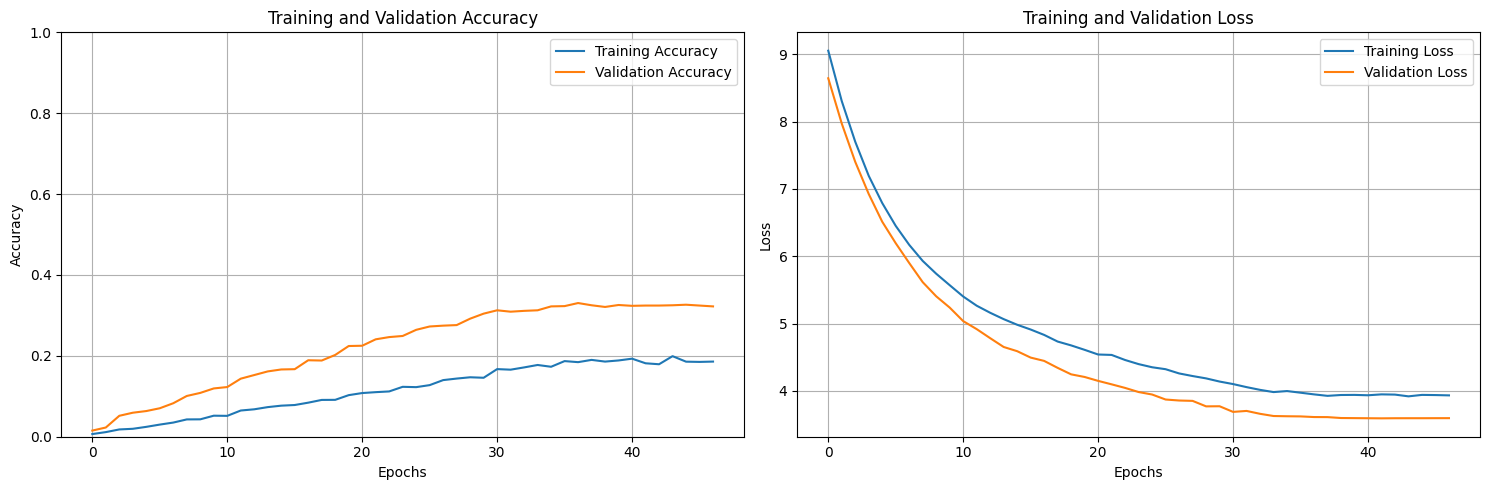

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_ylim([0, 1])
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Plot loss
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# **Evaluation**

In [9]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy (Top-1 Accuracy): {test_accuracy * 100:.2f}%")

# Predict on the entire test dataset
y_pred = np.argmax(model.predict(test_ds), axis=-1)
y_true = np.concatenate([np.argmax(y, axis=-1) for _, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)

# Calculate accuracy for each class
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

average_accuracy_per_class = np.mean(per_class_accuracy)
print(f"Average Accuracy per Class: {average_accuracy_per_class * 100:.2f}%")

38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.3841 - loss: 3.4883
Test Accuracy (Top-1 Accuracy): 31.56%
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step
Average Accuracy per Class: 31.87%


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


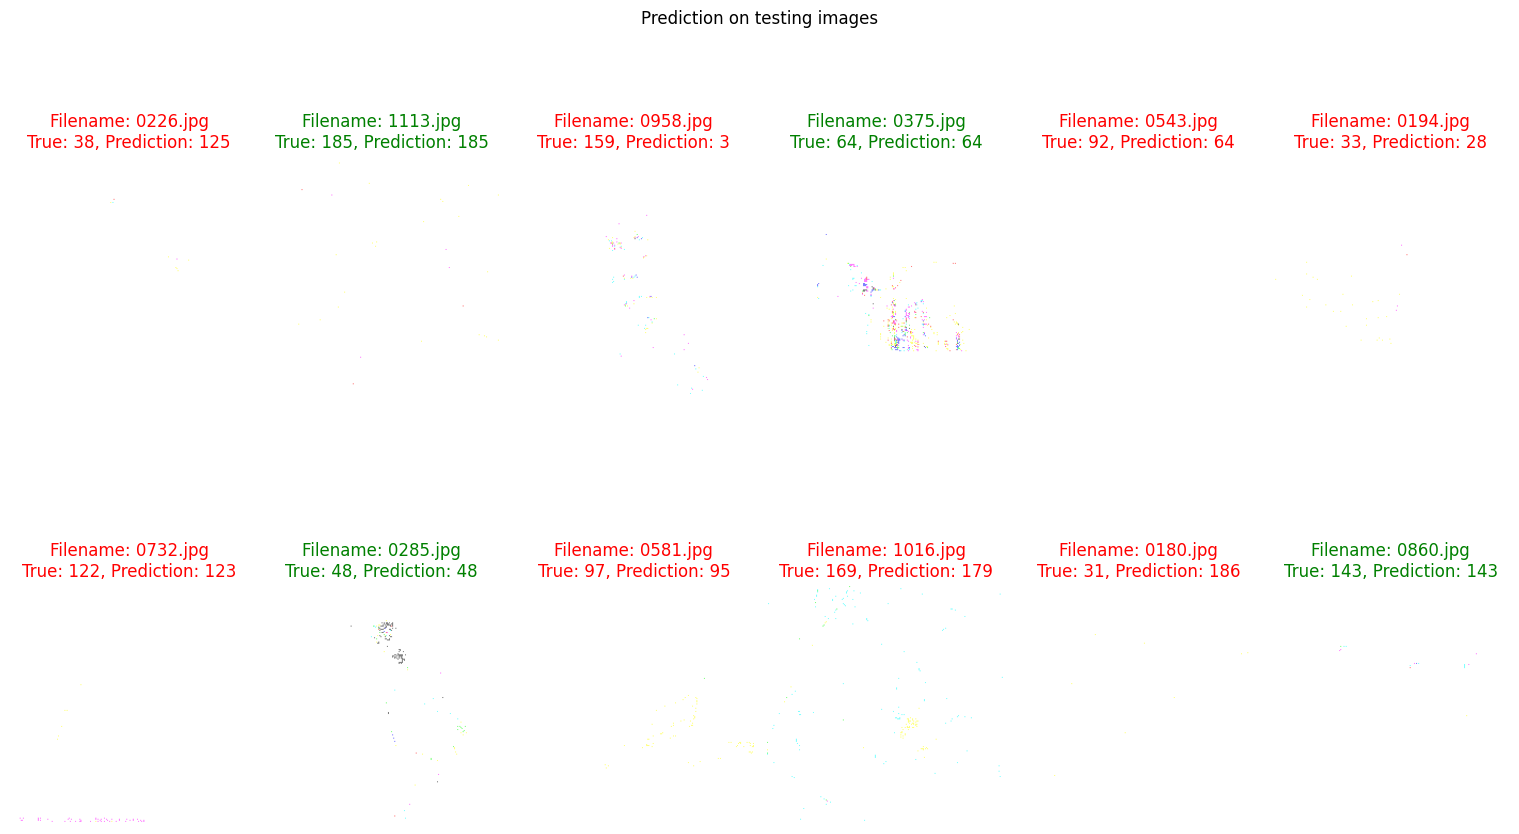

In [10]:
def plot_and_predict(model, test_images, test_labels, filenames, num_images):
    plt.figure(figsize=(15, 10))
    rows = num_images // 6 + (num_images % 6 > 0)
    for i in range(num_images):
        idx = random.randint(0, len(test_images) - 1)
        img = test_images[idx]
        filename = filenames[idx]
        true_label = np.argmax(test_labels[idx])

        prediction = model.predict(np.expand_dims(img, axis=0))
        predicted_label = np.argmax(prediction)
        
        if true_label == predicted_label:
            color = 'green'
        else:
            color = 'red'

        plt.subplot(rows, 6, i + 1)
        plt.imshow((img + 1) / 2)
        plt.title(f"Filename: {filename}\nTrue: {true_label}, Prediction: {predicted_label}", color=color)
        plt.axis('off')

    plt.tight_layout(pad=0, h_pad=0, w_pad=1.0)
    plt.suptitle("Prediction on testing images")
    plt.show()

# Load filenames from the text file
filenames = [os.path.basename(line.split()[0]) for line in open(test_txt).readlines()]

plot_and_predict(model, test_images, test_labels, filenames, num_images=12)